In [49]:
from dolfinx import mesh
import numpy as np
from mpi4py import MPI
import ufl
import gotranx
import monodomain 
import results
%reload_ext autoreload 

In [3]:
%autoreload
monodomain.translateODE("tentusscher_panfilov_2006_epi_cell", [gotranx.schemes.Scheme.generalized_rush_larsen])

2024-11-29 13:22:55 [info     ] Load ode /Users/alexanderhatle/Documents/Computing the Electrical Activity in the Heart/odes/tentusscher_panfilov_2006_epi_cell.ode
2024-11-29 13:22:55 [info     ] Num states 19                 
2024-11-29 13:22:55 [info     ] Num parameters 53             


In [32]:
def initial_v(x):
    return -85*np.cos(2*np.pi * x[0])

def initial_s(x):
    return 0*x[0]

def I_stim(x, t, lam, M):
    condition = ufl.And(x[0]<0.5, x[1]<0.5)
    return 2 * ufl.sin(t) *ufl.conditional(condition, 60, 0)

In [ ]:
%autoreload

h = 0.05
dt = 0.01
theta = 0.5
pde = monodomain.PDESolver(h, dt, theta, M = 1, lam = 1)

N = int(np.ceil(1/h))
domain = mesh.create_unit_square(MPI.COMM_WORLD, N, N, mesh.CellType.quadrilateral)
pde.set_mesh(domain, lagrange_order=2)
pde.initialize_vn(initial_v)

pde.set_stimulus(I_stim)
pde.setup_solver()

sn = pde.interpolate_func(initial_s)
num_nodes = len(pde.vn.x.array)
ode = monodomain.ODESolver(odefile="fitzhughnagumo", scheme="generalized_rush_larsen", num_nodes=num_nodes, initial_states=[pde.vn, sn], state_names=["v", "s"])
ode.set_param("stim_amplitude", 0)

solver = monodomain.MonodomainSolver(pde, ode)
vn, x, t = solver.solve(T=10, vtx_title="fitz")

In [55]:
%autoreload
def I_stim(x, t, lam, M):
    condition = ufl.And(x[0]<0.1, ufl.And(t>0.5, t<4))
    return ufl.conditional(condition, 200, 0)

h = 0.05
dt = 0.01
theta = 0.5
pde = monodomain.PDESolver(h, dt, theta, M = 1, lam = 1)

N = int(np.ceil(1/h))
domain = mesh.create_unit_square(MPI.COMM_WORLD, N, N, mesh.CellType.quadrilateral)
pde.set_mesh(domain, lagrange_order=2)
pde.set_stimulus(I_stim)
pde.setup_solver()
num_nodes = pde.V.dofmap.index_map.size_global
ode = monodomain.ODESolver(odefile="tentusscher_panfilov_2006_epi_cell", scheme="generalized_rush_larsen", num_nodes=num_nodes, v_name="V")
ode.set_param("stim_amplitude", 0)

solver = monodomain.MonodomainSolver(pde, ode)
vn, x, t = solver.solve(T=10, vtx_title="tentusscher")

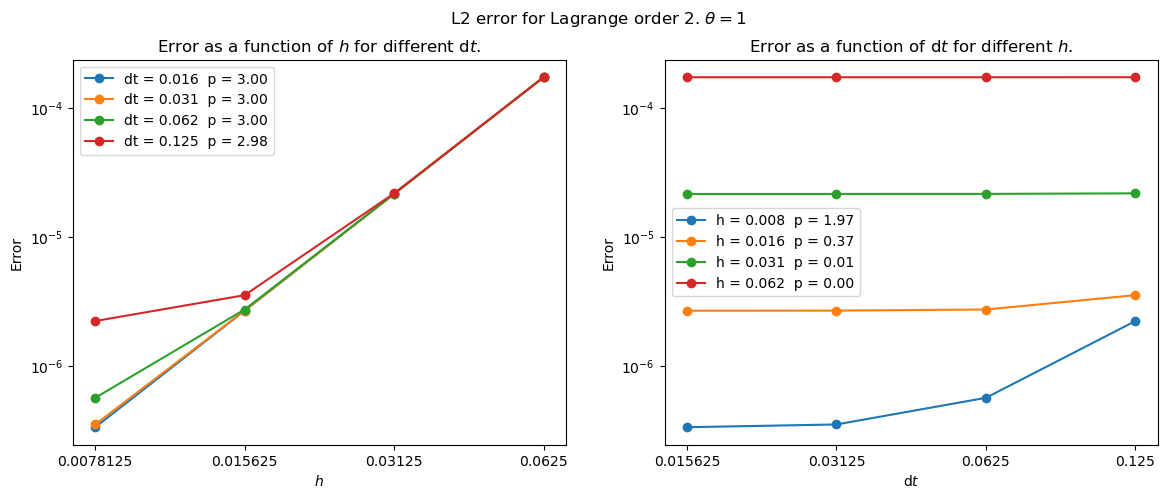

In [20]:
%autoreload
hs = [1/(2**i) for i in range(7, 3, -1)]
dts = [1/(2**i) for i in range(6, 2, -1)]

results.convergence_plot(hs, dts, theta=1, lagrange_order=2)

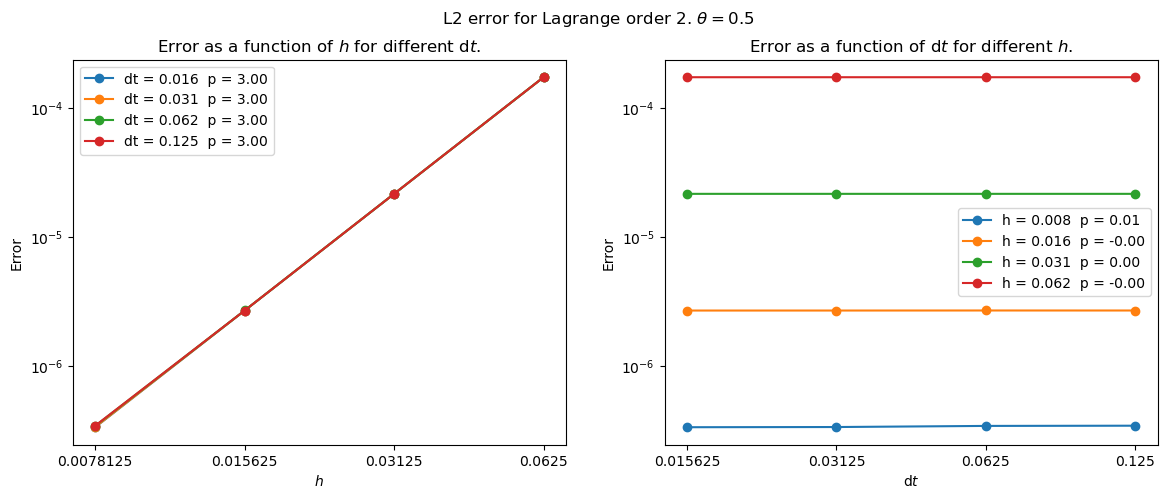

In [ ]:
%autoreload
hs = [1/(2**i) for i in range(7, 3, -1)]
dts = [1/(2**i) for i in range(6, 2, -1)]

results.convergence_plot(hs, dts, theta=0.5, lagrange_order=2)

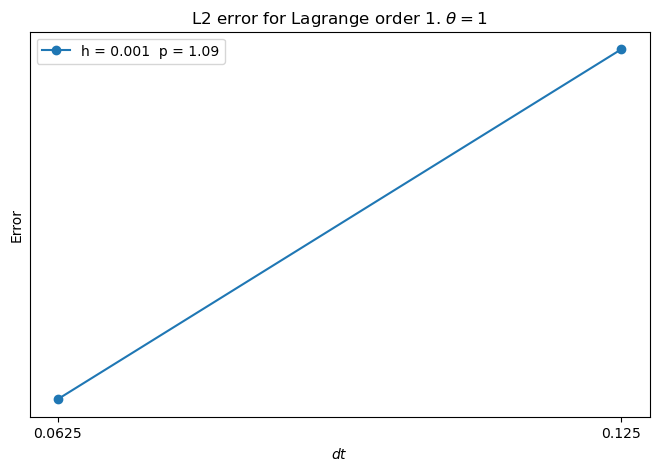

In [ ]:
%autoreload
h = 2**(-10)
dts = [2**(-i) for i in range(4, 2, -1)]
results.convergence_plot(h, dts, theta=1, lagrange_order=1)

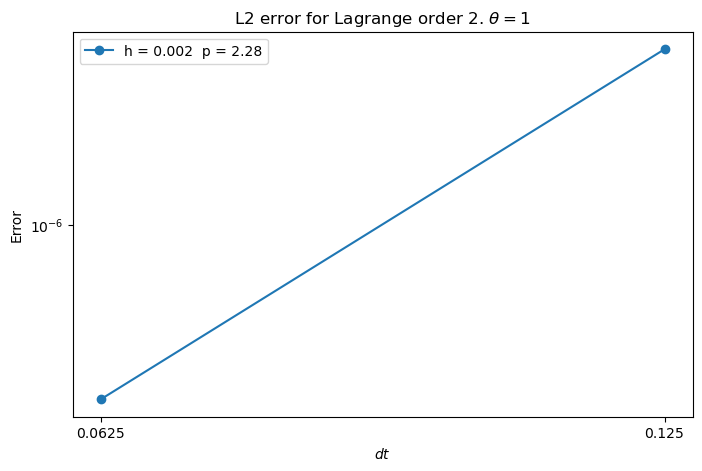

In [ ]:
h = 2**(-9)
dts = [2**(-i) for i in range(4, 2, -1)]
results.convergence_plot(h, dts, theta=1, lagrange_order=2)

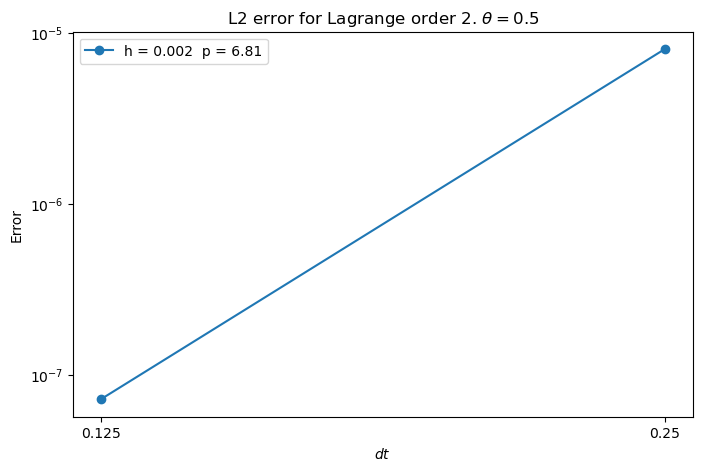

In [ ]:
h = 2**(-9)
dts = [2**(-i) for i in range(3, 1, -1)]
results.convergence_plot(h, dts, theta=0.5, lagrange_order=2)